<a href="https://colab.research.google.com/github/HaileyTheSynth/CSM-Astra/blob/main/CMBCheckForHSCWLanganrian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!sudo apt install libhealpix-cxx-dev
!pip install healpy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libhealpix-cxx3 libsharp0
The following NEW packages will be installed:
  libhealpix-cxx-dev libhealpix-cxx3 libsharp0
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 598 kB of archives.
After this operation, 2,642 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libsharp0 amd64 1.0.0-2 [78.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libhealpix-cxx3 amd64 3.80.0-5 [223 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libhealpix-cxx-dev amd64 3.80.0-5 [296 kB]
Fetched 598 kB in 0s (1,495 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling b

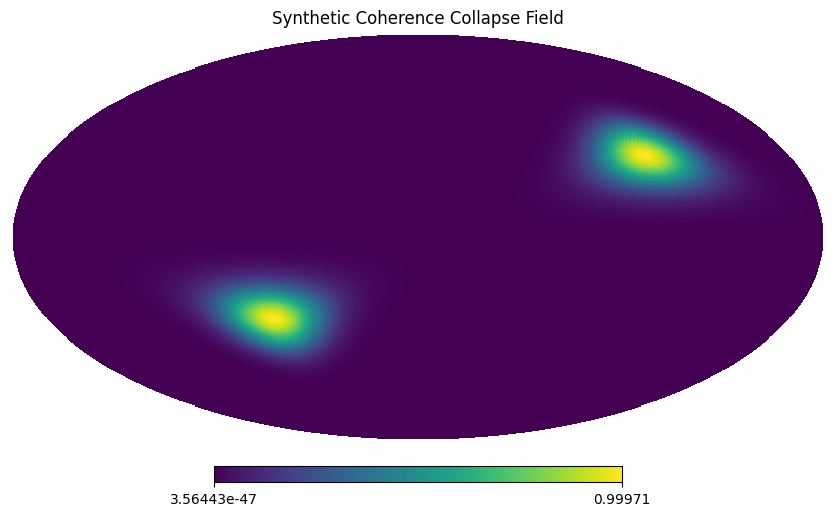

In [3]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

nside = 64  # Small for testing
npix = hp.nside2npix(nside)
theta, phi = hp.pix2ang(nside, np.arange(npix))  # spherical coordinates

# YOUR FIELD – directional drop near (l, b) = (-110, 60)
l = np.radians(250)  # converting to 0–360
b = np.radians(60)

# Angular distance from your axis
cos_angle = (np.sin(b) * np.sin(theta) +
             np.cos(b) * np.cos(theta) * np.cos(phi - l))
distance = np.arccos(np.clip(cos_angle, -1, 1))

# Mock coherence field: collapse strength drops with angle
coherence_field = np.exp(-distance**2 / (0.2**2))

# Visualize
hp.mollview(coherence_field, title="Synthetic Coherence Collapse Field")
plt.show()


In [4]:
alm = hp.map2alm(coherence_field, lmax=3)

In [5]:
from healpy.rotator import Rotator
import numpy as np

def get_axis_from_alm(alm, l):
    """Rough estimate of preferred axis from max |Ylm| component."""
    m_vals = np.arange(-l, l+1)
    abs_vals = np.abs(hp.alm2map(np.array([alm[hp.Alm.getidx(lmax=3, l=l, m=m)]
                                          if m >= 0 else 0 for m in m_vals]),
                                nside=64, lmax=3))
    max_pix = np.argmax(abs_vals)
    theta, phi = hp.pix2ang(64, max_pix)
    return np.degrees(theta), np.degrees(phi)


In [6]:
quad_axis = get_axis_from_alm(alm, 2)
oct_axis = get_axis_from_alm(alm, 3)
print("Quadrupole Axis:", quad_axis)
print("Octupole Axis:", oct_axis)

ValueError: Wrong alm size.

In [7]:
def extract_alm_for_l(alm_full, l_extract, lmax):
    """Return a zero-padded alm array with only coefficients for l=l_extract."""
    alm_out = np.zeros_like(alm_full, dtype=np.complex128)
    for m in range(l_extract + 1):  # only m >= 0 in HEALPix real maps
        idx = hp.Alm.getidx(lmax, l_extract, m)
        alm_out[idx] = alm_full[idx]
    return alm_out

# Extract your alm coefficients
lmax = 3
alm_full = hp.map2alm(coherence_field, lmax=lmax)

# Build individual components
alm_quad = extract_alm_for_l(alm_full, 2, lmax)
alm_oct = extract_alm_for_l(alm_full, 3, lmax)


In [8]:
def get_dominant_direction(alm, lmax=3, nside=64):
    # Convert back to map
    temp_map = hp.alm2map(alm, nside=nside, lmax=lmax, verbose=False)
    max_pix = np.argmax(np.abs(temp_map))
    theta, phi = hp.pix2ang(nside, max_pix)
    return np.degrees(theta), np.degrees(phi)


In [9]:
quad_axis = get_dominant_direction(alm_quad)
oct_axis = get_dominant_direction(alm_oct)
print("Quadrupole Axis:", quad_axis)
print("Octupole Axis:", oct_axis)


Quadrupole Axis: (np.float64(60.68680103583166), np.float64(250.31249999999997))
Octupole Axis: (np.float64(66.03051768224033), np.float64(230.62499999999994))


<ipython-input-8-000a5838ddba>:3: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  temp_map = hp.alm2map(alm, nside=nside, lmax=lmax, verbose=False)


In [10]:
def angular_separation(theta1, phi1, theta2, phi2):
    from numpy import cos, sin, arccos, radians, degrees, clip
    theta1, phi1, theta2, phi2 = map(radians, [theta1, phi1, theta2, phi2])
    angle = arccos(clip(
        sin(theta1)*sin(theta2)*cos(phi1 - phi2) + cos(theta1)*cos(theta2), -1.0, 1.0))
    return degrees(angle)

sep = angular_separation(*quad_axis, *oct_axis)
print("Angle between quadrupole and octupole axes:", sep, "degrees")


Angle between quadrupole and octupole axes: 18.363202413159158 degrees
